# ASHRAE - Great Energy Predictor III


Our aim in this competition is to predict energy consumption of buildings.

There are 4 types of energy to predict:

 - 0: electricity
 - 1: chilledwater
 - 2: steam
 - 3: hotwater

Electricity and water consumption may have different behavior!
So I tried to separately train & predict the model.

I moved previous [ASHRAE: Simple LGBM submission](https://www.kaggle.com/corochann/ashrae-simple-lgbm-submission) kernel.

**[Update] I published "[Optuna tutorial for hyperparameter optimization](https://www.kaggle.com/corochann/optuna-tutorial-for-hyperparameter-optimization)" notebook.
Please also check it :)**

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb


/tmp/ipykernel_728432/581457963.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Fast data loading

This kernel uses the preprocessed data from my previous kernel, [
ASHRAE: feather format for fast loading](https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading), to accelerate data loading!

In [70]:
root = Path('/data/elastic-notebook/data/ashrae-feather-format')

train_df = pd.read_feather(root/'train.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

In [71]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [72]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

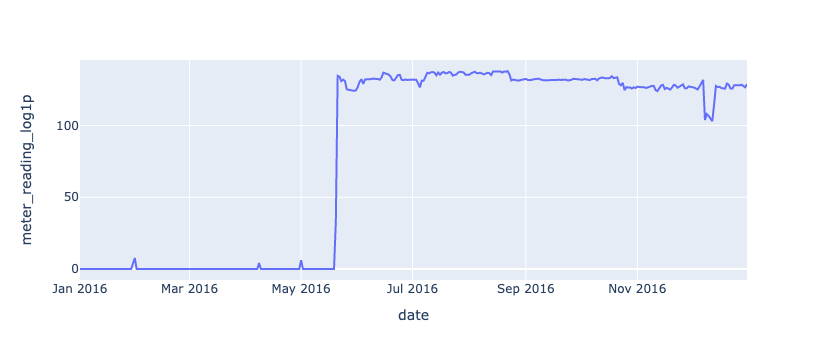

In [73]:
plot_date_usage(train_df, meter=0, building_id=0)

## Removing weired data on site_id 0

As you can see above, this data looks weired until May 20. It is reported in [this discussion](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588) by @barnwellguy that **All electricity meter is 0 until May 20 for site_id == 0**. I will remove these data from training data.

It corresponds to `building_id <= 104`.

In [74]:
building_meta_df[building_meta_df.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
100,0,100,Lodging/residential,24456,1968.0,NaN
101,0,101,Office,18860,1986.0,NaN
102,0,102,Office,15876,1983.0,NaN
103,0,103,Education,21657,2016.0,NaN


In [75]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Data preprocessing

Now, Let's try building GBDT (Gradient Boost Decision Tree) model to predict `meter_reading_log1p`. I will try using LightGBM in this notebook.

In [76]:
debug = False

# Add time feature

Some features introduced in https://www.kaggle.com/ryches/simple-lgbm-solution by @ryches

Features that are likely predictive:

#### Weather

- time of day
- holiday
- weekend
- cloud_coverage + lags
- dew_temperature + lags
- precip_depth + lags
- sea_level_pressure + lags
- wind_direction + lags
- wind_speed + lags

#### Train

- max, mean, min, std of the specific building historically



However we should be careful of putting time feature, since we have only 1 year data in training,
including `date` makes overfiting to training data.

How about `month`? It may be better to check performance by cross validation.
I go not using this data in this kernel for robust modeling.

In [77]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [78]:
preprocess(train_df)

In [79]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)

In [80]:
building_mean.head()

building_id
0    5.433594
1    4.761719
2    2.998047
3    5.875000
4    7.343750
Name: meter_reading_log1p, dtype: float16

# Fill Nan value in weather dataframe by interpolation


weather data has a lot of NaNs!!

![](http://)I tried to fill these values by **interpolating** data.

In [81]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0
1,0,2016-01-01 01:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5
2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [82]:
# weather_train_df.describe()

In [83]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [84]:
weather_train_df.shape

(139773, 9)

In [85]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,3,3830,3,1,85,250,0
1,0,0,1,7062,1,8763,52,3,0
2,0,0,1,2354,1,66,44,591,5
3,0,0,4,3642,6,37,158,153,4
4,0,0,0,4230,2,1317,73,105,0
5,0,0,2,6030,2,8755,8755,295,3
6,0,0,10,2992,10,0,175,779,39
7,0,0,0,8614,23,7883,8,0,0
8,0,0,3,3830,3,1,85,250,0


In [87]:
tmp = weather_train_df['timestamp']
weather_train_df.loc[:, weather_train_df.columns != 'timestamp'] = weather_train_df.groupby('site_id').apply(lambda group: group.loc[:, group.columns != 'timestamp'].interpolate(limit_direction='both'))
weather_train_df['timestamp'] = tmp

In [89]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


Seems number of nan has reduced by `interpolate` but some property has never appear in specific `site_id`, and nan remains for these features.

## lags

Adding some lag feature

In [90]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [91]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [92]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,-1.0,1019.700012,0.0,0.0,25.000000,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2016-01-01 01:00:00,24.400000,4.0,21.1,-1.0,1020.200012,70.0,1.5,24.703125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,24.062500,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,22.765625,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,21.296875,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [93]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_speed_max_lag

In [94]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


1788

In [95]:
reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1459.10 MB
Memory usage after optimization is: 776.94 MB
Decreased by 46.8%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 24.2%
Memory usage of dataframe is 19.86 MB
Memory usage after optimization is: 18.00 MB
Decreased by 9.4%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2016-01-01 00:00:00,25.000000,6.0,20.000000,-1.0,1019.5,0.0,0.000000,25.000000,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2016-01-01 01:00:00,24.406250,4.0,21.093750,-1.0,1020.0,70.0,1.500000,24.703125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2016-01-01 02:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000,24.062500,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2016-01-01 03:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000,22.765625,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609,21.296875,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.000000,1.5,-8.000000,-1.0,1007.5,180.0,5.699219,2.666016,...,1000.0,6.726562,211.000000,310.0,0.0,72.00000,5.046875,11.296875,0.0,2.525391
139769,15,2016-12-31 20:00:00,2.800781,2.0,-8.898438,-1.0,1007.5,180.0,7.699219,2.867188,...,1000.0,6.578125,209.875000,310.0,0.0,71.87500,5.125000,11.296875,0.0,2.519531
139770,15,2016-12-31 21:00:00,2.800781,2.0,-7.199219,-1.0,1007.5,180.0,5.101562,2.867188,...,1000.0,6.421875,212.375000,310.0,0.0,67.43750,5.195312,11.296875,0.0,2.443359
139771,15,2016-12-31 22:00:00,2.199219,2.0,-6.699219,-1.0,1008.0,170.0,4.601562,2.599609,...,1000.0,6.246094,211.375000,310.0,0.0,67.56250,5.226562,11.296875,0.0,2.423828


In [96]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


# Train model

To win in kaggle competition, how to evaluate your model is important.
What kind of cross validation strategy is suitable for this competition? This is time series data, so it is better to consider time-splitting.

However this notebook is for simple tutorial, so I will proceed with KFold splitting without shuffling, so that at least near-term data is not included in validation.

In [97]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', # 'month' , 'dayofweek'
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3']

In [98]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

In [99]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [100]:
folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle)

# Train model by each meter type

target_meter 0 (11714696, 34)
cat_features [31, 32, 33]
train 9371756 valid 2342940
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7645
[LightGBM] [Info] Number of data points in the train set: 9371756, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.107987
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.680818	valid_1's l2: 0.718861
[40]	training's l2: 0.41395	valid_1's l2: 0.489825
[60]	training's l2: 0.355364	valid_1's l2: 0.453576
[80]	training's l2: 0.323926	valid_1's l2: 0.448672
[100]	training's l2: 0.297006	valid_1's l2: 0.448243
Early stopping, best iteration is:
[93]	training's l2: 0.304926	valid_1's l2: 0.445637
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.304926378088176)]), 'valid_1': OrderedDict([('l2', 0.44563663768905293)])})
train 9371757 valid 2342939
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7764
[LightGBM] [Info] Number of data points in the train set: 9371757, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.110739
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.705173	valid_1's l2: 0.636493
[40]	training's l2: 0.439824	valid_1's l2: 0.373417
[60]	training's l2: 0.380389	valid_1's l2: 0.325092
[80]	training's l2: 0.348574	valid_1's l2: 0.315511
[100]	training's l2: 0.316428	valid_1's l2: 0.318796
Early stopping, best iteration is:
[88]	training's l2: 0.336913	valid_1's l2: 0.31371
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.33691268806828406)]), 'valid_1': OrderedDict([('l2', 0.313710415691174)])})
train 9371757 valid 2342939
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7722
[LightGBM] [Info] Number of data points in the train set: 9371757, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.083091
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.670046	valid_1's l2: 0.781666
[40]	training's l2: 0.407234	valid_1's l2: 0.524252
[60]	training's l2: 0.352281	valid_1's l2: 0.471396
[80]	training's l2: 0.320804	valid_1's l2: 0.448695
[100]	training's l2: 0.294302	valid_1's l2: 0.437126
[120]	training's l2: 0.276434	valid_1's l2: 0.431343
[140]	training's l2: 0.264063	valid_1's l2: 0.427485
[160]	training's l2: 0.250624	valid_1's l2: 0.426017
[180]	training's l2: 0.24056	valid_1's l2: 0.425113
Early stopping, best iteration is:
[177]	training's l2: 0.242566	valid_1's l2: 0.424775
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.24256599539896784)]), 'valid_1': OrderedDict([('l2', 0.4247753553135092)])})
train 9371757 valid 2342939
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7745
[LightGBM] [Info] Number of data points in the train set: 9371757, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.080643
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.659314	valid_1's l2: 0.825627
[40]	training's l2: 0.397142	valid_1's l2: 0.572519
[60]	training's l2: 0.342904	valid_1's l2: 0.52154
[80]	training's l2: 0.31769	valid_1's l2: 0.505114
[100]	training's l2: 0.298451	valid_1's l2: 0.495458
[120]	training's l2: 0.279065	valid_1's l2: 0.495067
Early stopping, best iteration is:
[113]	training's l2: 0.286271	valid_1's l2: 0.493499
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.2862705067445437)]), 'valid_1': OrderedDict([('l2', 0.4934993021639311)])})
train 9371757 valid 2342939
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7713
[LightGBM] [Info] Number of data points in the train set: 9371757, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.088317
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.686907	valid_1's l2: 0.67902
[40]	training's l2: 0.41898	valid_1's l2: 0.463074
[60]	training's l2: 0.356116	valid_1's l2: 0.436754
[80]	training's l2: 0.320303	valid_1's l2: 0.439511
Early stopping, best iteration is:
[69]	training's l2: 0.338525	valid_1's l2: 0.436402
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.33852463910549396)]), 'valid_1': OrderedDict([('l2', 0.43640244237960774)])})


/tmp/ipykernel_728432/1097397468.py:25: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




177

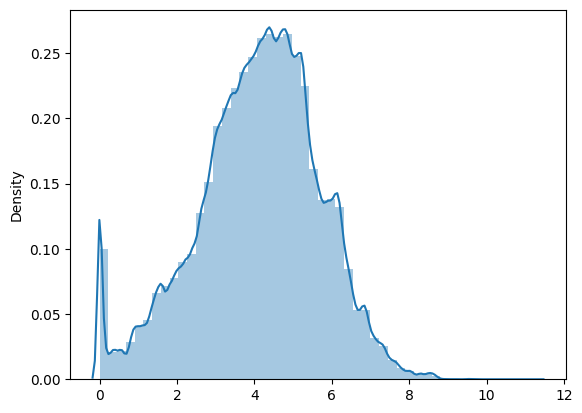

In [101]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

In [102]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

target_meter 1 (4182440, 34)
cat_features [31, 32, 33]
train 3345952 valid 836488
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6547
[LightGBM] [Info] Number of data points in the train set: 3345952, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.495145
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.4527	valid_1's l2: 2.89637
[40]	training's l2: 1.72175	valid_1's l2: 1.99552
[60]	training's l2: 1.47068	valid_1's l2: 1.79615
[80]	training's l2: 1.34624	valid_1's l2: 1.73081
[100]	training's l2: 1.26589	valid_1's l2: 1.70107
[120]	training's l2: 1.20741	valid_1's l2: 1.69045
[140]	training's l2: 1.1595	valid_1's l2: 1.68519
[160]	training's l2: 1.12001	valid_1's l2: 1.68018
[180]	training's l2: 1.08908	valid_1's l2: 1.67702
[200]	training's l2: 1.06124	valid_1's l2: 1.67408
[220]	training's l2: 1.03847	valid_1's l2: 1.67152
[240]	training's l2: 1.01896	valid_1's l2: 1.67399
Early stopping, best iteration is:
[226]	training's l2: 1.03212	valid_1's l2: 1.6706
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.0321186312528052)]), 'valid_1': OrderedDict([('l2', 1.670600943254926)])})
train 3345952 valid 836488


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6571
[LightGBM] [Info] Number of data points in the train set: 3345952, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.251517
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.43686	valid_1's l2: 2.5215
[40]	training's l2: 1.68484	valid_1's l2: 1.90773
[60]	training's l2: 1.43632	valid_1's l2: 1.7424
[80]	training's l2: 1.31596	valid_1's l2: 1.67499
[100]	training's l2: 1.23808	valid_1's l2: 1.62781
[120]	training's l2: 1.18646	valid_1's l2: 1.60728
[140]	training's l2: 1.138	valid_1's l2: 1.60149
[160]	training's l2: 1.10612	valid_1's l2: 1.59143
[180]	training's l2: 1.07329	valid_1's l2: 1.58313
[200]	training's l2: 1.04711	valid_1's l2: 1.57762
[220]	training's l2: 1.02357	valid_1's l2: 1.57372
[240]	training's l2: 1.00198	valid_1's l2: 1.57261
[260]	training's l2: 0.982361	valid_1's l2: 1.56905
[280]	training's l2: 0.963929	valid_1's l2: 1.56506
[300]	training's l2: 0.948115	valid_1's l2: 1.56375
Early stopping, best iteration is:
[290]	training's l2: 0.955985	valid_1's l2: 1.56293
best_score defaultdict(<class 'collecti

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6560
[LightGBM] [Info] Number of data points in the train set: 3345952, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 3.989627
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.47645	valid_1's l2: 2.90225
[40]	training's l2: 1.69443	valid_1's l2: 2.05062
[60]	training's l2: 1.4623	valid_1's l2: 1.7877
[80]	training's l2: 1.3517	valid_1's l2: 1.68737
[100]	training's l2: 1.28182	valid_1's l2: 1.63424
[120]	training's l2: 1.23345	valid_1's l2: 1.60327
[140]	training's l2: 1.19769	valid_1's l2: 1.59597
[160]	training's l2: 1.16688	valid_1's l2: 1.58789
[180]	training's l2: 1.13922	valid_1's l2: 1.5919
Early stopping, best iteration is:
[168]	training's l2: 1.15545	valid_1's l2: 1.58352
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.1554482661590721)]), 'valid_1': OrderedDict([('l2', 1.5835221054102206)])})
train 3345952 valid 836488
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6537
[LightGBM] [Info] Number of data points in the train set: 3345952, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.067399
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.30999	valid_1's l2: 3.15191
[40]	training's l2: 1.53378	valid_1's l2: 2.56885
[60]	training's l2: 1.29861	valid_1's l2: 2.42261
[80]	training's l2: 1.19155	valid_1's l2: 2.37005
[100]	training's l2: 1.12486	valid_1's l2: 2.33658
[120]	training's l2: 1.0826	valid_1's l2: 2.31604
[140]	training's l2: 1.04923	valid_1's l2: 2.303
[160]	training's l2: 1.02253	valid_1's l2: 2.3144
Early stopping, best iteration is:
[146]	training's l2: 1.04157	valid_1's l2: 2.30104
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.0415688330502364)]), 'valid_1': OrderedDict([('l2', 2.3010399218712045)])})
train 3345952 valid 836488
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6509
[LightGBM] [Info] Number of data points in the train set: 3345952, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.426561
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.44704	valid_1's l2: 2.55969
[40]	training's l2: 1.70082	valid_1's l2: 1.88454
[60]	training's l2: 1.43619	valid_1's l2: 1.78434
[80]	training's l2: 1.31151	valid_1's l2: 1.75488
[100]	training's l2: 1.23111	valid_1's l2: 1.74499
[120]	training's l2: 1.17411	valid_1's l2: 1.7405
[140]	training's l2: 1.12757	valid_1's l2: 1.7433
Early stopping, best iteration is:
[123]	training's l2: 1.16429	valid_1's l2: 1.73961
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.1642878491793909)]), 'valid_1': OrderedDict([('l2', 1.7396105050991342)])})


/tmp/ipykernel_728432/3861202855.py:25: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




202

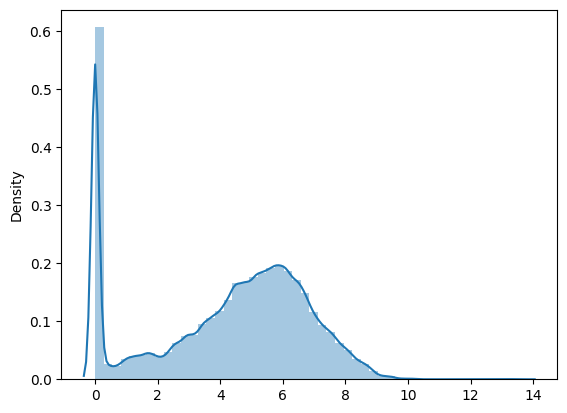

In [103]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 2 (2708713, 34)
cat_features [31, 32, 33]
train 2166970 valid 541743
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6323
[LightGBM] [Info] Number of data points in the train set: 2166970, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 4.917709
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.58751	valid_1's l2: 3.19318
[40]	training's l2: 1.89144	valid_1's l2: 2.59867
[60]	training's l2: 1.70813	valid_1's l2: 2.49447
[80]	training's l2: 1.59556	valid_1's l2: 2.47113
[100]	training's l2: 1.52451	valid_1's l2: 2.47108
[120]	training's l2: 1.4684	valid_1's l2: 2.46947
Early stopping, best iteration is:
[108]	training's l2: 1.50303	valid_1's l2: 2.46376
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.5030318719761788)]), 'valid_1': OrderedDict([('l2', 2.4637638000228232)])})
train 2166970 valid 541743
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6356
[LightGBM] [Info] Number of data points in the train set: 2166970, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 5.129545
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.56211	valid_1's l2: 2.92628
[40]	training's l2: 1.83751	valid_1's l2: 2.42458
[60]	training's l2: 1.639	valid_1's l2: 2.35347
[80]	training's l2: 1.53501	valid_1's l2: 2.31634
[100]	training's l2: 1.46984	valid_1's l2: 2.28352
[120]	training's l2: 1.42041	valid_1's l2: 2.26113
[140]	training's l2: 1.38256	valid_1's l2: 2.24785
[160]	training's l2: 1.34955	valid_1's l2: 2.23864
[180]	training's l2: 1.32179	valid_1's l2: 2.23796
[200]	training's l2: 1.2967	valid_1's l2: 2.23001
[220]	training's l2: 1.2748	valid_1's l2: 2.22504
[240]	training's l2: 1.25654	valid_1's l2: 2.22114
[260]	training's l2: 1.23518	valid_1's l2: 2.21301
[280]	training's l2: 1.21817	valid_1's l2: 2.20942
[300]	training's l2: 1.19771	valid_1's l2: 2.21004
Early stopping, best iteration is:
[284]	training's l2: 1.21469	valid_1's l2: 2.2075
best_score defaultdict(<class 'collections.O

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6331
[LightGBM] [Info] Number of data points in the train set: 2166970, number of used features: 34
[LightGBM] [Info] Start training from score 5.341834


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.59572	valid_1's l2: 3.3039
[40]	training's l2: 1.91264	valid_1's l2: 2.38105
[60]	training's l2: 1.71256	valid_1's l2: 2.15055
[80]	training's l2: 1.60257	valid_1's l2: 2.06883
[100]	training's l2: 1.52739	valid_1's l2: 2.03049
[120]	training's l2: 1.46876	valid_1's l2: 2.01135
[140]	training's l2: 1.42326	valid_1's l2: 1.99818
[160]	training's l2: 1.38532	valid_1's l2: 1.98705
[180]	training's l2: 1.3549	valid_1's l2: 1.9797
[200]	training's l2: 1.32476	valid_1's l2: 1.97905
[220]	training's l2: 1.30182	valid_1's l2: 1.97331
[240]	training's l2: 1.28022	valid_1's l2: 1.97165
[260]	training's l2: 1.25591	valid_1's l2: 1.96941
Early stopping, best iteration is:
[256]	training's l2: 1.26019	valid_1's l2: 1.96828
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.2601948523471949)]), 'valid_1': OrderedDict([('l2', 1.9682830581088608)])})
train 2166971 valid 541742
t

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6312
[LightGBM] [Info] Number of data points in the train set: 2166971, number of used features: 34


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[LightGBM] [Info] Start training from score 5.286079
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.51095	valid_1's l2: 3.3098
[40]	training's l2: 1.79997	valid_1's l2: 2.69031
[60]	training's l2: 1.60787	valid_1's l2: 2.59552
[80]	training's l2: 1.51976	valid_1's l2: 2.57318
[100]	training's l2: 1.45262	valid_1's l2: 2.56951
[120]	training's l2: 1.40093	valid_1's l2: 2.55775
[140]	training's l2: 1.36102	valid_1's l2: 2.55608
Early stopping, best iteration is:
[135]	training's l2: 1.37065	valid_1's l2: 2.55032
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.3706480074214806)]), 'valid_1': OrderedDict([('l2', 2.550321524412401)])})
train 2166971 valid 541742
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6289
[LightGBM] [Info] Number of data points in the train set: 2166971, number of used features: 34
[LightGBM] [Info] Start training from score 4.940269


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.69058	valid_1's l2: 2.4843
[40]	training's l2: 1.94623	valid_1's l2: 2.07758
[60]	training's l2: 1.72102	valid_1's l2: 2.08264
Early stopping, best iteration is:
[54]	training's l2: 1.77835	valid_1's l2: 2.06604
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.7783531487271884)]), 'valid_1': OrderedDict([('l2', 2.066041802189035)])})


/tmp/ipykernel_728432/1040628066.py:26: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




97

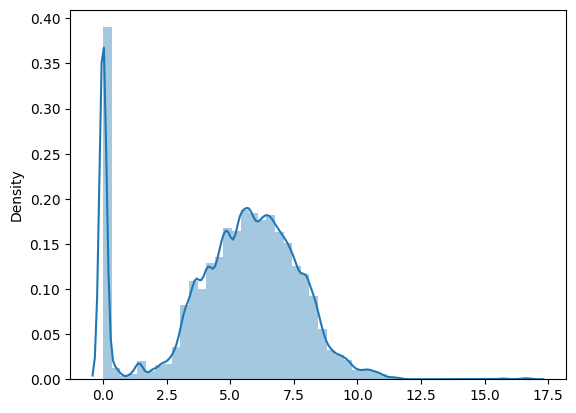

In [104]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 3 (1264037, 34)
cat_features [31, 32, 33]
train 1011229 valid 252808
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6126
[LightGBM] [Info] Number of data points in the train set: 1011229, number of used features: 34
[LightGBM] [Info] Start training from score 3.050406


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 20 rounds
[20]	training's l2: 3.50791	valid_1's l2: 4.25452
[40]	training's l2: 2.48613	valid_1's l2: 3.12899
[60]	training's l2: 2.12832	valid_1's l2: 2.69797
[80]	training's l2: 1.96981	valid_1's l2: 2.53538
[100]	training's l2: 1.88023	valid_1's l2: 2.4679
[120]	training's l2: 1.81459	valid_1's l2: 2.42449
[140]	training's l2: 1.76286	valid_1's l2: 2.39288
[160]	training's l2: 1.72108	valid_1's l2: 2.37608
[180]	training's l2: 1.68305	valid_1's l2: 2.36813
[200]	training's l2: 1.65083	valid_1's l2: 2.3614
[220]	training's l2: 1.62025	valid_1's l2: 2.35967
[240]	training's l2: 1.59355	valid_1's l2: 2.36056
Early stopping, best iteration is:
[234]	training's l2: 1.60065	valid_1's l2: 2.35861
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.6006485807202704)]), 'valid_1': OrderedDict([('l2', 2.358606931114274)])})
train 1011229 valid 252808
training LGB:


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 1011229, number of used features: 34
[LightGBM] [Info] Start training from score 3.309855


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 20 rounds
[20]	training's l2: 3.4819	valid_1's l2: 3.68981
[40]	training's l2: 2.38566	valid_1's l2: 2.90758
[60]	training's l2: 2.00299	valid_1's l2: 2.68614
[80]	training's l2: 1.84455	valid_1's l2: 2.63835
[100]	training's l2: 1.76316	valid_1's l2: 2.62573
[120]	training's l2: 1.70362	valid_1's l2: 2.62419
[140]	training's l2: 1.65371	valid_1's l2: 2.61344
[160]	training's l2: 1.61353	valid_1's l2: 2.61155
[180]	training's l2: 1.58048	valid_1's l2: 2.61017
[200]	training's l2: 1.55017	valid_1's l2: 2.60326
[220]	training's l2: 1.5252	valid_1's l2: 2.59465
[240]	training's l2: 1.50277	valid_1's l2: 2.59066
[260]	training's l2: 1.48372	valid_1's l2: 2.58677
[280]	training's l2: 1.46715	valid_1's l2: 2.58299
[300]	training's l2: 1.44978	valid_1's l2: 2.58002
[320]	training's l2: 1.43649	valid_1's l2: 2.57511
Early stopping, best iteration is:
[314]	training's l2: 1.4401	valid_1's l2: 2.57485
best_score defaultdict(<class 'collections.O

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6154
[LightGBM] [Info] Number of data points in the train set: 1011230, number of used features: 34
[LightGBM] [Info] Start training from score 3.526880
Training until validation scores don't improve for 20 rounds


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[20]	training's l2: 3.62646	valid_1's l2: 3.53535
[40]	training's l2: 2.6087	valid_1's l2: 2.30309
[60]	training's l2: 2.2462	valid_1's l2: 1.89383
[80]	training's l2: 2.09087	valid_1's l2: 1.7454
[100]	training's l2: 1.99767	valid_1's l2: 1.6664
[120]	training's l2: 1.92541	valid_1's l2: 1.62454
[140]	training's l2: 1.87443	valid_1's l2: 1.61066
[160]	training's l2: 1.83141	valid_1's l2: 1.58848
[180]	training's l2: 1.79488	valid_1's l2: 1.57804
[200]	training's l2: 1.76177	valid_1's l2: 1.56367
[220]	training's l2: 1.73066	valid_1's l2: 1.55432
[240]	training's l2: 1.70527	valid_1's l2: 1.54735
[260]	training's l2: 1.68047	valid_1's l2: 1.54355
[280]	training's l2: 1.65793	valid_1's l2: 1.53917
[300]	training's l2: 1.63883	valid_1's l2: 1.53515
[320]	training's l2: 1.62062	valid_1's l2: 1.53254
[340]	training's l2: 1.59987	valid_1's l2: 1.53027
[360]	training's l2: 1.58146	valid_1's l2: 1.528
Early stopping, best iteration is:
[359]	training's l2: 1.58192	valid_1's l2: 1.52799
best_s

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6078
[LightGBM] [Info] Number of data points in the train set: 1011230, number of used features: 34
[LightGBM] [Info] Start training from score 3.533689
Training until validation scores don't improve for 20 rounds


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[20]	training's l2: 3.45658	valid_1's l2: 4.08333
[40]	training's l2: 2.40575	valid_1's l2: 3.04827
[60]	training's l2: 2.03677	valid_1's l2: 2.7243
[80]	training's l2: 1.88631	valid_1's l2: 2.60925
[100]	training's l2: 1.80689	valid_1's l2: 2.56868
[120]	training's l2: 1.74785	valid_1's l2: 2.54185
[140]	training's l2: 1.70427	valid_1's l2: 2.52756
[160]	training's l2: 1.66568	valid_1's l2: 2.52038
[180]	training's l2: 1.63318	valid_1's l2: 2.51418
[200]	training's l2: 1.60076	valid_1's l2: 2.49974
[220]	training's l2: 1.57404	valid_1's l2: 2.4848
[240]	training's l2: 1.55066	valid_1's l2: 2.48391
[260]	training's l2: 1.52828	valid_1's l2: 2.47963
[280]	training's l2: 1.50926	valid_1's l2: 2.47417
[300]	training's l2: 1.49412	valid_1's l2: 2.47031
[320]	training's l2: 1.48058	valid_1's l2: 2.47099
Early stopping, best iteration is:
[310]	training's l2: 1.4875	valid_1's l2: 2.46957
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.487495968077

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6205
[LightGBM] [Info] Number of data points in the train set: 1011230, number of used features: 34
[LightGBM] [Info] Start training from score 3.201819
Training until validation scores don't improve for 20 rounds


/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[20]	training's l2: 3.43046	valid_1's l2: 3.96398
[40]	training's l2: 2.35324	valid_1's l2: 3.11098
[60]	training's l2: 1.9637	valid_1's l2: 2.87789
[80]	training's l2: 1.79985	valid_1's l2: 2.8262
[100]	training's l2: 1.70774	valid_1's l2: 2.82456
Early stopping, best iteration is:
[89]	training's l2: 1.75104	valid_1's l2: 2.81984
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.7510350910863277)]), 'valid_1': OrderedDict([('l2', 2.8198438398996455)])})


/tmp/ipykernel_728432/2201829904.py:26: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




177

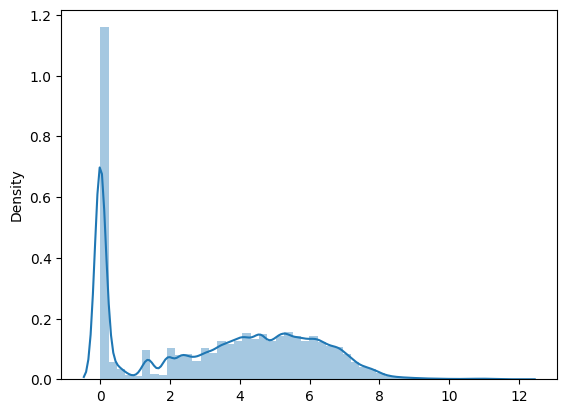

In [105]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

# Prediction on test data

In [107]:
print('loading...')
test_df = pd.read_feather(root/'test.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)

print('preprocessing weather...')
tmp = weather_test_df['timestamp']
weather_test_df.loc[:, weather_test_df.columns != 'timestamp'] = weather_test_df.groupby('site_id').apply(lambda group: group.loc[:, group.columns != 'timestamp'].interpolate(limit_direction='both'))
weather_test_df['timestamp'] = tmp
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage...')
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...
preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 2584.79 MB
Memory usage after optimization is: 1232.77 MB
Decreased by 52.3%
Memory usage of dataframe is 39.40 MB
Memory usage after optimization is: 35.69 MB
Decreased by 9.4%


6595

In [108]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
reduce_mem_usage(sample_submission)

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [109]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [110]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total


iterations 25
predicting 0-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/25 [00:00<?, ?it/s]

predicting 1-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/25 [00:00<?, ?it/s]

predicting 2-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/25 [00:00<?, ?it/s]

predicting 3-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/25 [00:00<?, ?it/s]

predicting 4-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/25 [00:00<?, ?it/s]

/tmp/ipykernel_728432/3933577357.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




212

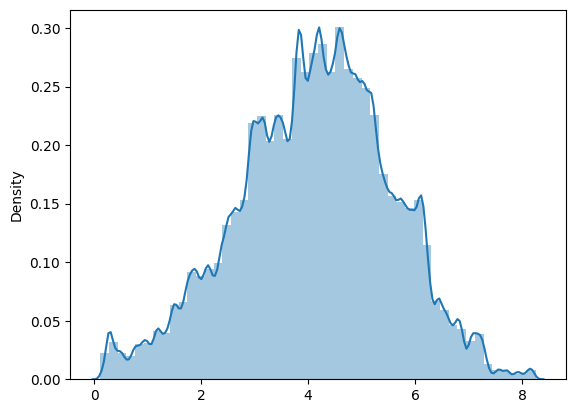

In [111]:
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
predicting 0-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/9 [00:00<?, ?it/s]

predicting 1-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/9 [00:00<?, ?it/s]

predicting 2-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/9 [00:00<?, ?it/s]

predicting 3-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/9 [00:00<?, ?it/s]

predicting 4-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_728432/1759057633.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




192

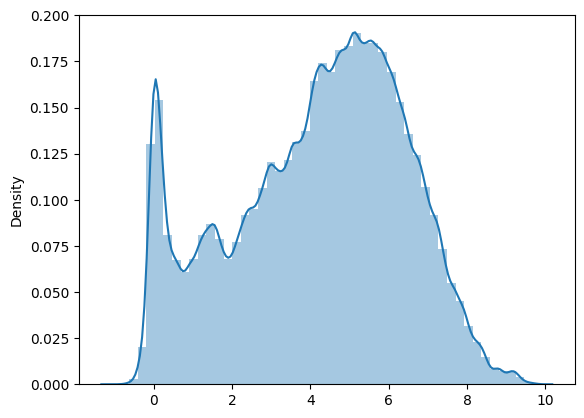

In [112]:
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
predicting 0-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

predicting 1-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

predicting 2-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

predicting 3-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

predicting 4-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_728432/534591690.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




117

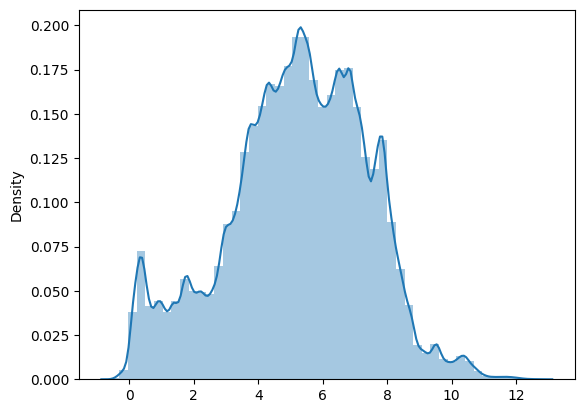

In [113]:
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
predicting 0-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/3 [00:00<?, ?it/s]

predicting 1-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/3 [00:00<?, ?it/s]

predicting 2-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/3 [00:00<?, ?it/s]

predicting 3-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/3 [00:00<?, ?it/s]

predicting 4-th model


/tmp/ipykernel_728432/1880116821.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_728432/2367980445.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




177

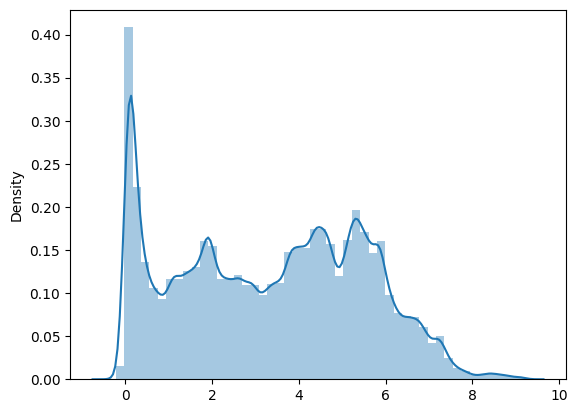

In [114]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [115]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [116]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

In [117]:
sample_submission.head()

,row_id,meter_reading
0,0,177.531387
1,1,89.592191
2,2,9.839608
3,3,307.674690
4,4,1376.683707


<AxesSubplot: >

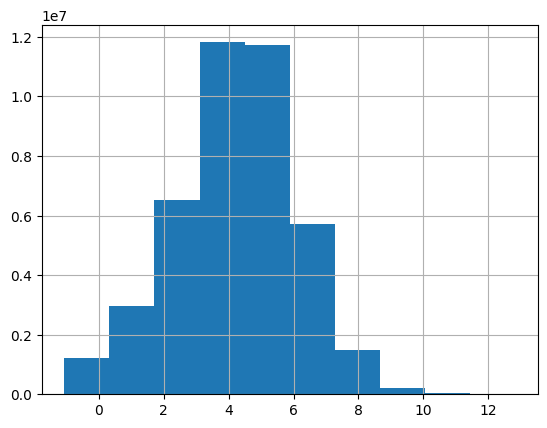

In [118]:
np.log1p(sample_submission['meter_reading']).hist()

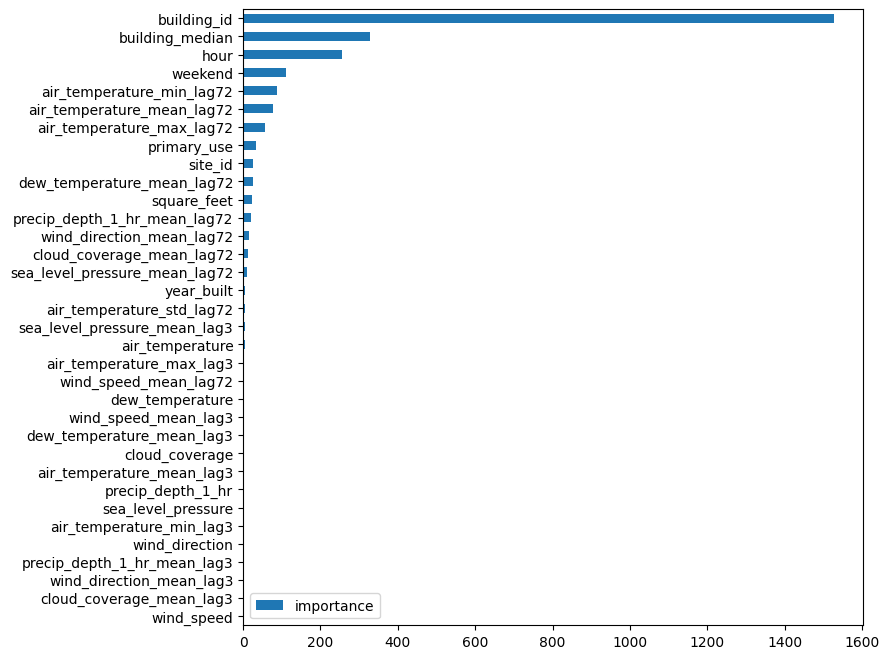

In [119]:
plot_feature_importance(models0[1])

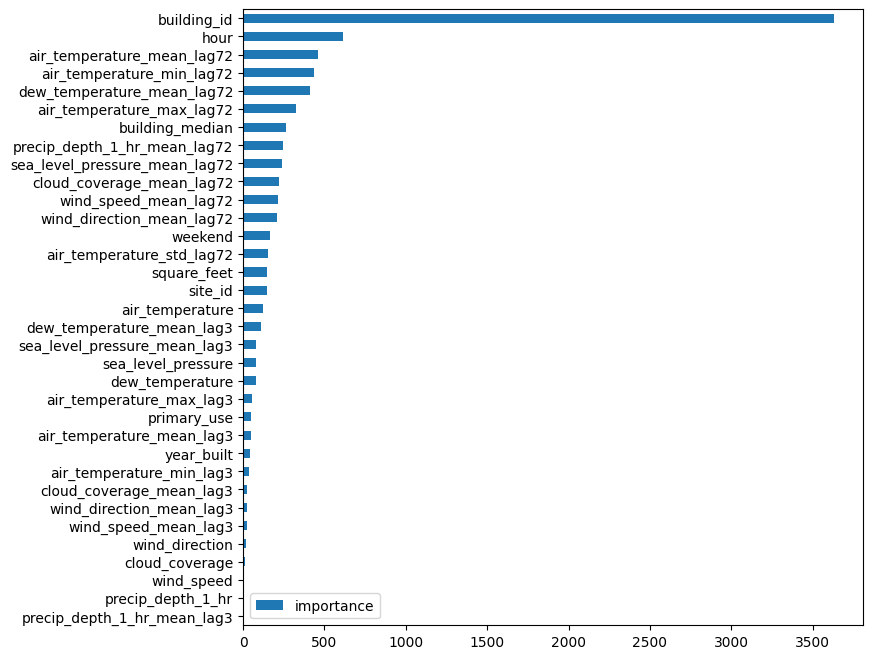

In [120]:
plot_feature_importance(models1[1])

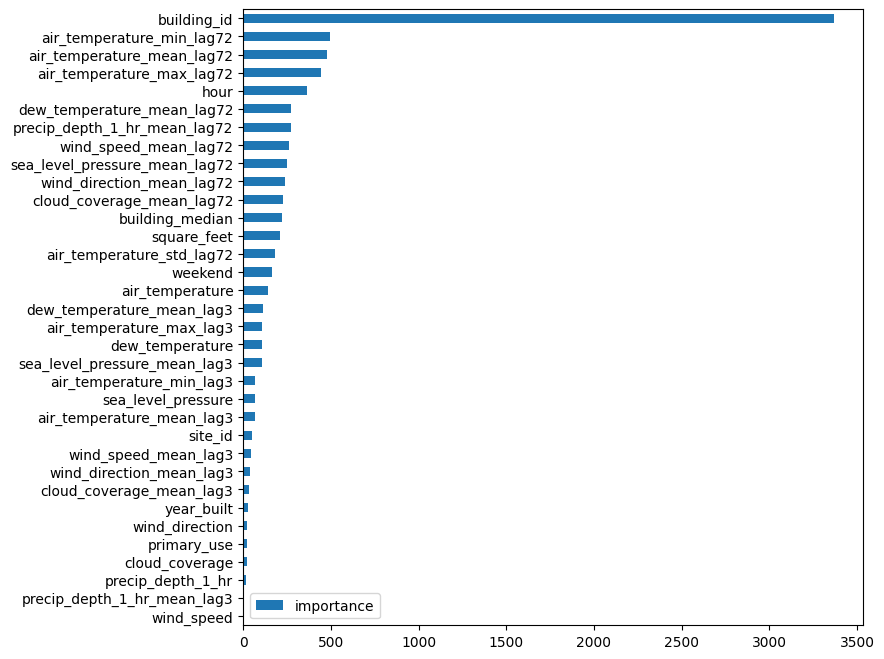

In [121]:
plot_feature_importance(models2[1])

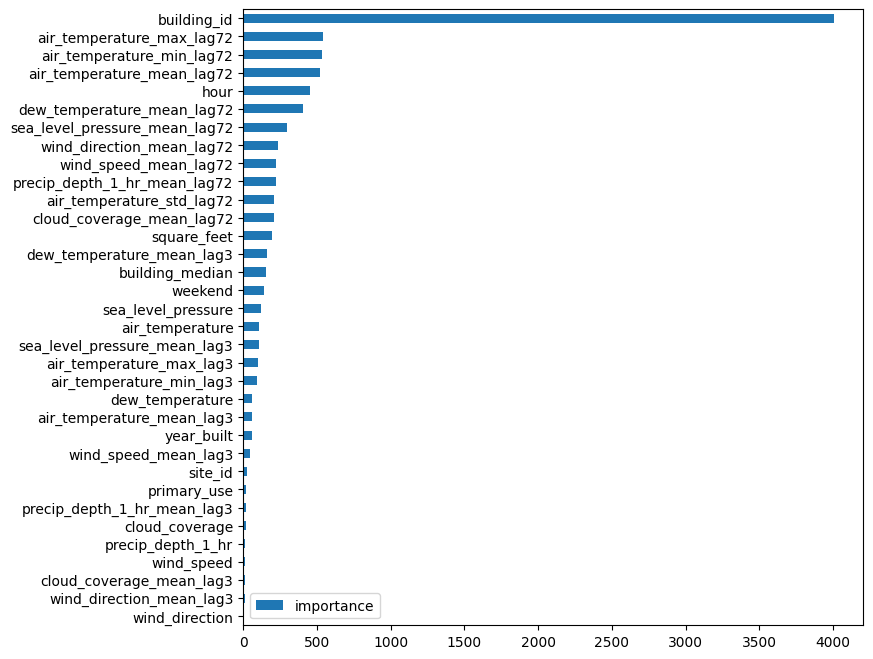

In [122]:
plot_feature_importance(models3[1])

# References

These kernels inspired me to write this kernel, thank you for sharing!

 - https://www.kaggle.com/rishabhiitbhu/ashrae-simple-eda
 - https://www.kaggle.com/isaienkov/simple-lightgbm
 - https://www.kaggle.com/ryches/simple-lgbm-solution